<a href="https://colab.research.google.com/github/Tieck-IT/Study/blob/main/tf_keras/%5BAutoEncoder%5Dmnet_segementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 폐 영역분할

다음의 2019 대한의료인공지능학회 Summer School에서 진행한 AI hands-on의 자료에서 코드르 가져와서 수정함.

https://github.com/mi2rl/ai_handson/blob/master/KoSAIM_Summer_School_2019_Handson_03_Segmentation.ipynb


## 폐 데이터 다운로드

다음에서 다운받은 데이터

https://www.kaggle.com/nikhilpandey360/lung-segmentation-from-chest-x-ray-dataset

In [1]:
!rm -rf Lung_Segmentation.zip
!wget https://github.com/dhrim/hongik_2020/raw/master/material/deep_learning/Lung_Segmentation.zip

--2022-01-04 06:01:10--  https://github.com/dhrim/hongik_2020/raw/master/material/deep_learning/Lung_Segmentation.zip
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dhrim/hongik_2020/master/material/deep_learning/Lung_Segmentation.zip [following]
--2022-01-04 06:01:11--  https://raw.githubusercontent.com/dhrim/hongik_2020/master/material/deep_learning/Lung_Segmentation.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37648324 (36M) [application/zip]
Saving to: ‘Lung_Segmentation.zip’

Lung_Segmentation.z 100%[===================>]  35.90M   205MB/s    in 0.2s    

2022-01-04 06:01:12 (20

In [2]:
!rm -rf Lung_Segmentation
!unzip Lung_Segmentation.zip

Archive:  Lung_Segmentation.zip
   creating: Lung_Segmentation/
   creating: Lung_Segmentation/image/
  inflating: Lung_Segmentation/image/CHNCXR_0001_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0002_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0003_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0004_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0005_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0006_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0007_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0008_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0009_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0010_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0011_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0012_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0013_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0014_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0015_0.png  
  inflating: Lung_Segmentation/image/CHNCXR

## 풀린 데이터 파일 구조

```
Lung_segmentaiton/
  image/
    CHNCXR_0001_0.png
    CHNCXR_0002_0.png
    ...
  label/
    CHNCXR_0001_0.png
    CHNCXR_0002_0.png
    ...
```

## 파일 보기

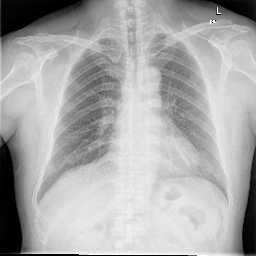

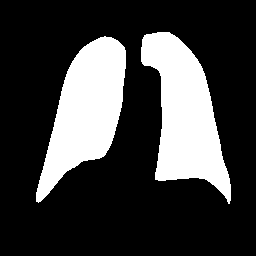

In [3]:
from IPython.display import Image, display

display(Image('./Lung_Segmentation/image/CHNCXR_0001_0.png'))
display(Image('./Lung_Segmentation/label/CHNCXR_0001_0.png'))


## 데이터 로딩

In [4]:
import numpy as np
import os

from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

data_path = "Lung_Segmentation"

files = os.listdir(os.path.join(data_path, 'image'))
# files = ['CHNCXR_0402_1.png', 'CHNCXR_0461_1.png', 'CHNCXR_0422_1.png', ... ]    


raw_x = []
raw_y = []
for file_name in files:
    # file_name = "CHNCXR_0402_1"

    # input_file = "./Lung_Segmentation/image/CHNCXR_0402_1.png"
    input_file = os.path.join(data_path, 'image', file_name)
    # output_file = "./Lung_Segmentation/label/CHNCXR_0402_1.png"
    output_file = os.path.join(data_path, 'label', file_name)
    
    image = imread(input_file)[:,:,:IMG_CHANNELS]
    # image.shape = (256, 256, 3)

    label = imread(output_file)
    # label.shape = (256, 256)

    label = np.expand_dims(label, axis=-1)
    # label.shape = (256, 256, 1)

    raw_x.append(image)
    raw_y.append(label)

raw_x = np.array(raw_x)
raw_y = np.array(raw_y)

## 원시 데이터 보기

In [5]:
print(raw_x[0])
print(raw_y[0])

[[[ 75  75  75]
  [ 37  37  37]
  [ 28  28  28]
  ...
  [ 46  46  46]
  [ 54  54  54]
  [ 62  62  62]]

 [[ 73  73  73]
  [ 35  35  35]
  [ 24  24  24]
  ...
  [ 45  45  45]
  [ 50  50  50]
  [ 53  53  53]]

 [[ 72  72  72]
  [ 32  32  32]
  [ 20  20  20]
  ...
  [ 42  42  42]
  [ 45  45  45]
  [ 50  50  50]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 42  42  42]
  [ 42  42  42]
  [ 56  56  56]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 70  70  70]
  [ 71  71  71]
  [ 79  79  79]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [109 109 109]
  [111 111 111]
  [112 112 112]]]
[[[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 ...

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]]


## 데이터 정규화

In [6]:
x = raw_x.astype('float32') / 255.
y = raw_y.astype('float32')

## 데이터 나누기

In [8]:
split_index = int(raw_x.shape[0]*0.8)
train_x, test_x = x[:split_index], x[split_index:]
train_y, test_y = y[:split_index], y[split_index:]

In [9]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(452, 256, 256, 3)
(452, 256, 256, 1)
(114, 256, 256, 3)
(114, 256, 256, 1)


train


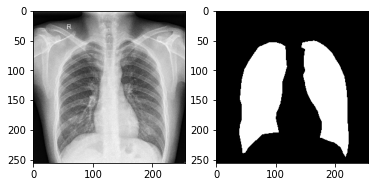

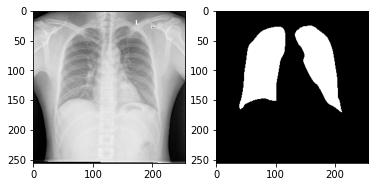

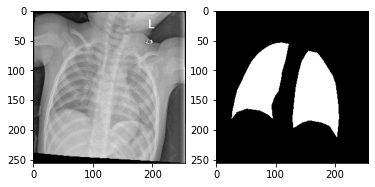

test


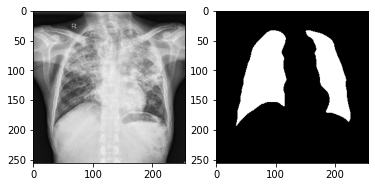

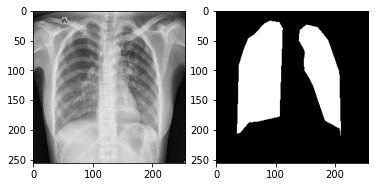

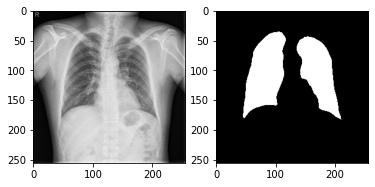

In [10]:
import matplotlib.pyplot as plt

def plotTrainData(x, y, set_type):
    print(set_type)  
    for i in range(3):
        ix = np.random.randint(0, len(x))
        plt.subplot(1,2,1)
        plt.imshow(x[ix])
        
        plt.subplot(1,2,2)
        plt.imshow(np.squeeze(y[ix]), 'gray') # np.squeeze()는 (256,26,1)을 (256,256)으로 변환
        plt.show()
        
plotTrainData(train_x, train_y, 'train')
plotTrainData(test_x, test_y, 'test')

## M-Net 모델 정의

copy from https://github.com/adigasu/FDPMNet/blob/master/test.py

In [12]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Activation, Input, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, UpSampling2D
from tensorflow.keras import backend as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K


def getFPDMNet(patchHeight, patchWidth, ipCh, outCh):

    # Input
    input1 = Input((patchHeight, patchWidth, ipCh))

    # Encoder
    conv1 = Conv2D(16, (3, 3), padding='same')(input1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Dropout(0.2)(conv1)

    conv1 = concatenate([input1, conv1], axis=-1)
    conv1 = Conv2D(16, (3, 3), padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    #
    input2 = MaxPooling2D(pool_size=(2, 2))(input1)
    conv21 = concatenate([input2, pool1], axis=-1)

    conv2 = Conv2D(32, (3, 3), padding='same')(conv21)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Dropout(0.2)(conv2)

    conv2 = concatenate([conv21, conv2], axis=-1)
    conv2 = Conv2D(32, (3, 3), padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    #
    input3 = MaxPooling2D(pool_size=(2, 2))(input2)
    conv31 = concatenate([input3, pool2], axis=-1)

    conv3 = Conv2D(64, (3, 3), padding='same')(conv31)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Dropout(0.2)(conv3)
    
    conv3 = concatenate([conv31, conv3], axis=-1)
    conv3 = Conv2D(64, (3, 3), padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    #
    input4 = MaxPooling2D(pool_size=(2, 2))(input3)
    conv41 = concatenate([input4, pool3], axis=-1)

    conv4 = Conv2D(128, (3, 3), padding='same')(conv41)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Dropout(0.2)(conv4)
    
    conv4 = concatenate([conv41, conv4], axis=-1)
    conv4 = Conv2D(128, (3, 3), padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Dropout(0.2)(conv4)

    conv4 = Conv2D(128, (3, 3), padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)

    # Decoder
    conv5 = UpSampling2D(size=(2, 2))(conv4)
    conv51 = concatenate([conv3, conv5], axis=-1)

    conv5 = Conv2D(64, (3, 3), padding='same')(conv51)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Dropout(0.2)(conv5)
    
    conv5 = concatenate([conv51, conv5], axis=-1)
    conv5 = Conv2D(64, (3, 3), padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)

    #
    conv6 = UpSampling2D(size=(2, 2))(conv5)
    conv61 = concatenate([conv2, conv6], axis=-1)

    conv6 = Conv2D(32, (3, 3), padding='same')(conv61)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)
    conv6 = Dropout(0.2)(conv6)
    
    conv6 = concatenate([conv61, conv6], axis=-1)
    conv6 = Conv2D(32, (3, 3), padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)

    #
    conv7 = UpSampling2D(size=(2, 2))(conv6)
    conv71 = concatenate([conv1, conv7], axis=-1)

    conv7 = Conv2D(16, (3, 3), padding='same')(conv71)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = Dropout(0.2)(conv7)
    
    conv7 = concatenate([conv71, conv7], axis=-1)
    conv7 = Conv2D(16, (3, 3), padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)

    # Final
    conv81 = UpSampling2D(size=(8, 8))(conv4)
    conv82 = UpSampling2D(size=(4, 4))(conv5)
    conv83 = UpSampling2D(size=(2, 2))(conv6)
    conv8 = concatenate([conv81, conv82, conv83, conv7], axis=-1)
    conv8 = Conv2D(outCh, (1, 1), activation='sigmoid')(conv8)

    ############
    model = Model(inputs=input1, outputs=conv8)

    # sgd = SGD(learning_rate=lrate, decay=decay_Rate, momentum=0.75, nesterov=True)
    # model.compile(optimizer=sgd, loss=my_loss)

    return model

## 모델 컴파일과 학습

In [13]:
# 모델 생성
# model = unet()
model = getFPDMNet(patchHeight=256, patchWidth=256, ipCh=3, outCh=1)

# 모델 컴파일
# model.compile(loss="mse", optimizer="SGD", metrics=['accuracy'])

lrate = 0.1
decay_Rate = 1e-6

def my_loss(y_true, y_pred):
    l1_loss = K.mean(K.abs(y_pred - y_true))
    return l1_loss
sgd = SGD(learning_rate=lrate, decay=decay_Rate, momentum=0.75, nesterov=True)
model.compile(optimizer=sgd, loss=my_loss, metrics=['accuracy'])


# 학습
hist = model.fit(train_x, train_y, validation_split=0.2, epochs=20, batch_size=8, verbose=1)


Epoch 1/20
46/46 [==============================] - 20s 178ms/step - loss: 64.3889 - accuracy: 0.7069 - val_loss: 64.0139 - val_accuracy: 0.6050
Epoch 2/20
46/46 [==============================] - 5s 107ms/step - loss: 64.3458 - accuracy: 0.7286 - val_loss: 63.9742 - val_accuracy: 0.4739
Epoch 3/20
46/46 [==============================] - 5s 106ms/step - loss: 64.3331 - accuracy: 0.7322 - val_loss: 63.8759 - val_accuracy: 0.4828
Epoch 4/20
46/46 [==============================] - 5s 111ms/step - loss: 64.3278 - accuracy: 0.7341 - val_loss: 63.7297 - val_accuracy: 0.6288
Epoch 5/20
46/46 [==============================] - 5s 103ms/step - loss: 64.3238 - accuracy: 0.7361 - val_loss: 63.7064 - val_accuracy: 0.6486
Epoch 6/20
46/46 [==============================] - 5s 107ms/step - loss: 64.3236 - accuracy: 0.7355 - val_loss: 63.7991 - val_accuracy: 0.5393
Epoch 7/20
46/46 [==============================] - 5s 103ms/step - loss: 64.3213 - accuracy: 0.7367 - val_loss: 63.7309 - val_accuracy

## 학습시 로스와 정확도 보기

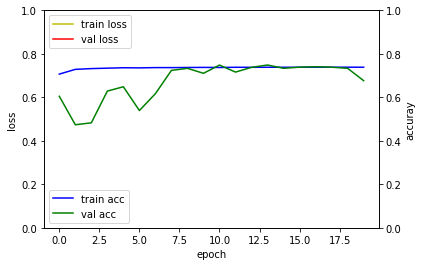

In [14]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 1.0])

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylim([0.0, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

## 테스트 결과 보기

In [15]:
import matplotlib.pyplot as plt

def plotPredictions(model, train_x, train_y, test_x, test_y):

    ix = np.random.randint(0, len(train_x))

    input_ = train_x[ix:ix+1]
    mask_ = train_y[ix:ix+1]

    preds_train = model.predict(input_)
    preds_train_t = (preds_train > 0.5).astype(np.uint8)

    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("X_train")
    plt.axis('off')
    plt.imshow(input_[0])
    plt.subplot(1,3,2)
    plt.title("Y_train")
    plt.axis('off')
    plt.imshow(mask_[0][:,:,0], 'gray')
    plt.subplot(1,3,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_train_t[0][:,:,0], 'gray')
    plt.show()

    ix = np.random.randint(0, len(test_x))
    input_ = test_x[ix:ix+1]
    mask_ = test_y[ix:ix+1]
    preds_test = model.predict(input_)
    preds_test_t = (preds_test > 0.5).astype(np.uint8)
    
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("X_test")
    plt.axis('off')
    plt.imshow(input_[0])
    plt.subplot(1,3,2)
    plt.title("Y_test")
    plt.axis('off')
    plt.imshow(mask_[0][:,:,0], 'gray')
    plt.subplot(1,3,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_test_t[0][:,:,0], 'gray')
    plt.show()

1/1 [==============================] - 0s 29ms/step - loss: 84.1549 - accuracy: 0.6074


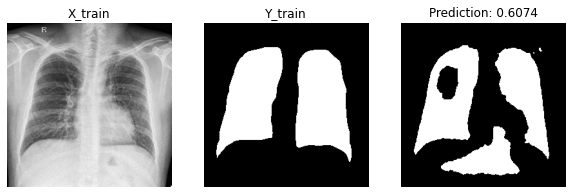

1/1 [==============================] - 0s 34ms/step - loss: 53.9990 - accuracy: 0.7024


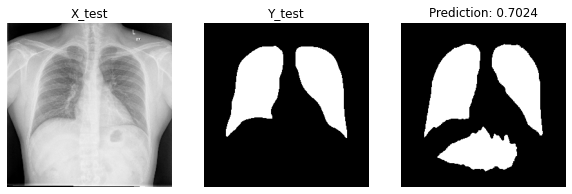

In [16]:
plotPredictions(model, train_x, train_y, test_x, test_y)

In [17]:
hist = model.fit(train_x, train_y, validation_split=0.2, epochs=100, batch_size=8, verbose=1)

Epoch 1/100
46/46 [==============================] - 5s 104ms/step - loss: 64.3155 - accuracy: 0.7387 - val_loss: 63.6603 - val_accuracy: 0.7466
Epoch 2/100
46/46 [==============================] - 5s 102ms/step - loss: 64.3153 - accuracy: 0.7390 - val_loss: 63.6094 - val_accuracy: 0.7379
Epoch 3/100
46/46 [==============================] - 5s 111ms/step - loss: 64.3151 - accuracy: 0.7387 - val_loss: 63.6311 - val_accuracy: 0.7103
Epoch 4/100
46/46 [==============================] - 5s 103ms/step - loss: 64.3153 - accuracy: 0.7385 - val_loss: 63.6323 - val_accuracy: 0.7441
Epoch 5/100
46/46 [==============================] - 5s 102ms/step - loss: 64.3153 - accuracy: 0.7387 - val_loss: 63.6099 - val_accuracy: 0.7422
Epoch 6/100
46/46 [==============================] - 5s 102ms/step - loss: 64.3147 - accuracy: 0.7390 - val_loss: 63.6088 - val_accuracy: 0.7364
Epoch 7/100
46/46 [==============================] - 5s 102ms/step - loss: 64.3148 - accuracy: 0.7390 - val_loss: 63.6098 - val_ac

1/1 [==============================] - 0s 28ms/step - loss: 73.6112 - accuracy: 0.7093


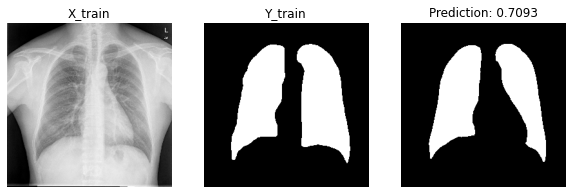

1/1 [==============================] - 0s 28ms/step - loss: 68.0055 - accuracy: 0.7256


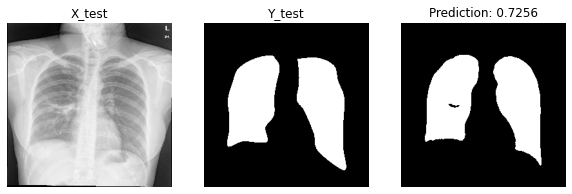

In [18]:
plotPredictions(model, train_x, train_y, test_x, test_y)